# TPHLCT 3階の導関数を相殺する

In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
from skimage.measure import compare_psnr as psnr
import pandas as pd

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

MONO_DIR_PATH = "../../Mono/"
OUTPUT_DIR_PATH = "../../Plot_tool/output/images/TPHLCT3/32x32/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")

Images = np.array(
    [
        AIRPLANE,
        BARBARA,
        BOAT,
        GOLDHILL,
        LENNA,
        MANDRILL,
        MILKDROP,
        SAILBOAT
    ]
)

N = 32

In [2]:
def msds(N,arr):
    w_e = 0
    e_e = 0
    n_e = 0
    s_e = 0
    nw_e = 0
    ne_e = 0
    sw_e = 0
    se_e = 0
    for row in range(arr.shape[0] // N):
        for col in range(arr.shape[1] // N):
            f_block = arr[row * N : (row + 1) * N, col * N : (col + 1) * N]
            # w
            if col == 0:
                w_block = np.fliplr(f_block)
            else:
                w_block = arr[row * N : (row + 1) * N, (col - 1) * N : col * N]
            # e
            if col == arr.shape[1] // N - 1:
                e_block = np.fliplr(f_block)
            else:
                e_block = arr[row * N : (row + 1) * N, (col + 1) * N : (col + 2) * N]
            # n
            if row == 0:
                n_block = np.flipud(f_block)
            else:
                n_block = arr[(row - 1) * N : row * N, col * N : (col + 1) * N]
            # s
            if row == arr.shape[0] // N - 1:
                s_block = np.flipud(f_block)
            else:
                s_block = arr[(row + 1) * N : (row + 2) * N, col * N : (col + 1) * N]

            w_d1 = f_block[:, 0] - w_block[:, N-1]
            e_d1 = f_block[:, N-1] - e_block[:, 0]
            n_d1 = f_block[0, :] - n_block[N-1, :]
            s_d1 = f_block[N-1, :] - s_block[0, :]

            w_d2 = (w_block[:, N-1] - w_block[:, N-2] + f_block[:, 1] - f_block[:, 0]) / 2
            e_d2 = (e_block[:, 1] - e_block[:, 0] + f_block[:, N-1] - f_block[:, N-2]) / 2
            n_d2 = (n_block[N-1, :] - n_block[N-2, :] + f_block[1, :] - f_block[0, :]) / 2
            s_d2 = (s_block[1, :] - s_block[0, :] + f_block[N-1, :] - f_block[N-2, :]) / 2

            w_e += np.sum((w_d1 - w_d2) ** 2 )
            e_e += np.sum((e_d1 - e_d2) ** 2 )
            n_e += np.sum((n_d1 - n_d2) ** 2)
            s_e += np.sum((s_d1 - s_d2) ** 2)

            # nw
            if row == 0 or col == 0:
                nw_block = np.flipud(np.fliplr(f_block))
            else:
                nw_block = arr[(row - 1) * N : row * N, (col - 1) * N : col * N]
            # ne
            if row == 0 or col == arr.shape[1] // N - 1:
                ne_block = np.flipud(np.fliplr(f_block))
            else:
                ne_block = arr[(row-1) * N : row * N, (col + 1) * N : (col + 2) * N]
            # sw
            if row == arr.shape[0] // N -1 or col == 0:
                sw_block = np.flipud(np.fliplr(f_block))
            else:
                sw_block = arr[row * N : (row+1) * N, (col-1) * N : col * N]
            # se
            if  row == arr.shape[0]//N-1 or col == arr.shape[0] // N -1:
                se_block = np.flipud(np.fliplr(f_block))
            else:
                se_block = arr[(row + 1) * N : (row + 2) * N, (col+1) * N : (col + 2) * N]

            nw_g1 = f_block[0, 0] - nw_block[N-1, N-1]
            ne_g1 = f_block[0, N-1] - ne_block[N-1, 0]
            sw_g1 = f_block[N-1, 0] - sw_block[0, N-1]
            se_g1 = f_block[N-1, N-1] - se_block[0, 0]

            nw_g2 = (nw_block[N-1,N-1] - nw_block[N-2,N-2] + f_block[1,1] - f_block[0,0])/2
            ne_g2 = (ne_block[N-1,0] - ne_block[N-2,1] + f_block[1,N-2] - f_block[0,N-1])/2
            sw_g2 = (sw_block[0,N-1] - nw_block[1,N-2] + f_block[N-2,1] - f_block[N-1,0])/2
            se_g2 = (nw_block[0,0] - nw_block[1,1] + f_block[N-2,N-2] - f_block[N-1,N-1])/2

            nw_e += (nw_g1 - nw_g2) ** 2 
            ne_e += (ne_g1 - ne_g2) ** 2 
            sw_e += (sw_g1 - sw_g2) ** 2 
            se_e += (se_g1 - se_g2) ** 2 

    MSDSt = (w_e + e_e + n_e + s_e + nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    MSDS1 = (w_e + e_e + n_e + s_e)/ ((arr.shape[0]/N)**2)
    MSDS2 = (nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    return MSDSt, MSDS1, MSDS2

findfont: Font family ['Source Han Sans JP'] not found. Falling back to DejaVu Sans.


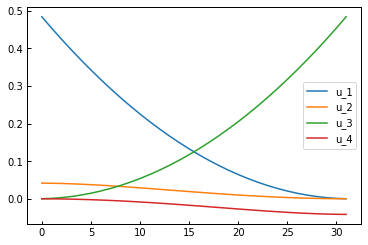

In [3]:
sampling_x = (0.5 + np.arange(N)) / N
u_1 = (1 - sampling_x) ** 2 / 2
u_2 = 1 / 24 - sampling_x ** 2 / 6 + sampling_x ** 3 / 6 - sampling_x ** 4 / 24
u_3 = sampling_x ** 2 / 2
u_4 = -sampling_x ** 2 / 12 + sampling_x ** 4 / 24
plt.plot(u_1, label="u_1")
plt.plot(u_2, label="u_2")
plt.plot(u_3, label="u_3")
plt.plot(u_4, label="u_4")
plt.legend()

In [4]:
ak = - scipy.fftpack.dct(u_1,norm="ortho")
ak

array([-9.42578864e-01, -8.10243674e-01, -2.02315746e-01, -8.97352733e-02,
       -5.03306486e-02, -3.20903214e-02, -2.21802622e-02, -1.62029774e-02,
       -1.23215704e-02, -9.65848827e-03, -7.75151710e-03, -6.33840654e-03,
       -5.26136563e-03, -4.42082807e-03, -3.75144214e-03, -3.20886401e-03,
       -2.76213586e-03, -2.38910402e-03, -2.07356609e-03, -1.80343954e-03,
       -1.56955394e-03, -1.36483505e-03, -1.18374180e-03, -1.02186977e-03,
       -8.75667049e-04, -7.42226865e-04, -6.19133680e-04, -5.04346991e-04,
       -3.96111897e-04, -2.92888805e-04, -1.93296799e-04, -9.60665949e-05])

In [5]:
bk = scipy.fftpack.dct(u_2,norm="ortho")
bk

array([1.09994382e-01, 8.21278487e-02, 5.13298176e-03, 1.01391469e-03,
       3.20802291e-04, 1.31394699e-04, 6.33601140e-05, 3.41952121e-05,
       2.00398805e-05, 1.25062623e-05, 8.20094224e-06, 5.59700060e-06,
       3.94751701e-06, 2.86162774e-06, 2.12308561e-06, 1.60652401e-06,
       1.23630756e-06, 9.65206497e-07, 7.62828824e-07, 6.09091833e-07,
       4.90407443e-07, 3.97383602e-07, 3.23400654e-07, 2.63707517e-07,
       2.14834779e-07, 1.74205550e-07, 1.39872296e-07, 1.10335392e-07,
       8.44154936e-08, 6.11617680e-08, 3.97841193e-08, 1.96014032e-08])

In [6]:
ck = scipy.fftpack.dct(u_3,norm="ortho")
ck

array([ 9.42578864e-01, -8.10243674e-01,  2.02315746e-01, -8.97352733e-02,
        5.03306486e-02, -3.20903214e-02,  2.21802622e-02, -1.62029774e-02,
        1.23215704e-02, -9.65848827e-03,  7.75151710e-03, -6.33840654e-03,
        5.26136563e-03, -4.42082807e-03,  3.75144214e-03, -3.20886401e-03,
        2.76213586e-03, -2.38910402e-03,  2.07356609e-03, -1.80343954e-03,
        1.56955394e-03, -1.36483505e-03,  1.18374180e-03, -1.02186977e-03,
        8.75667049e-04, -7.42226865e-04,  6.19133680e-04, -5.04346991e-04,
        3.96111897e-04, -2.92888805e-04,  1.93296799e-04, -9.60665949e-05])

In [7]:
dk = scipy.fftpack.dct(u_4,norm="ortho")
dk

array([-1.09994382e-01,  8.21278487e-02, -5.13298176e-03,  1.01391469e-03,
       -3.20802291e-04,  1.31394699e-04, -6.33601140e-05,  3.41952121e-05,
       -2.00398805e-05,  1.25062623e-05, -8.20094224e-06,  5.59700060e-06,
       -3.94751701e-06,  2.86162774e-06, -2.12308561e-06,  1.60652401e-06,
       -1.23630756e-06,  9.65206497e-07, -7.62828824e-07,  6.09091833e-07,
       -4.90407443e-07,  3.97383602e-07, -3.23400654e-07,  2.63707517e-07,
       -2.14834779e-07,  1.74205550e-07, -1.39872296e-07,  1.10335392e-07,
       -8.44154936e-08,  6.11617680e-08, -3.97841193e-08,  1.96014032e-08])

In [8]:
alpha = ak
alpha

array([-9.42578864e-01, -8.10243674e-01, -2.02315746e-01, -8.97352733e-02,
       -5.03306486e-02, -3.20903214e-02, -2.21802622e-02, -1.62029774e-02,
       -1.23215704e-02, -9.65848827e-03, -7.75151710e-03, -6.33840654e-03,
       -5.26136563e-03, -4.42082807e-03, -3.75144214e-03, -3.20886401e-03,
       -2.76213586e-03, -2.38910402e-03, -2.07356609e-03, -1.80343954e-03,
       -1.56955394e-03, -1.36483505e-03, -1.18374180e-03, -1.02186977e-03,
       -8.75667049e-04, -7.42226865e-04, -6.19133680e-04, -5.04346991e-04,
       -3.96111897e-04, -2.92888805e-04, -1.93296799e-04, -9.60665949e-05])

In [9]:
beta = ck
beta

array([ 9.42578864e-01, -8.10243674e-01,  2.02315746e-01, -8.97352733e-02,
        5.03306486e-02, -3.20903214e-02,  2.21802622e-02, -1.62029774e-02,
        1.23215704e-02, -9.65848827e-03,  7.75151710e-03, -6.33840654e-03,
        5.26136563e-03, -4.42082807e-03,  3.75144214e-03, -3.20886401e-03,
        2.76213586e-03, -2.38910402e-03,  2.07356609e-03, -1.80343954e-03,
        1.56955394e-03, -1.36483505e-03,  1.18374180e-03, -1.02186977e-03,
        8.75667049e-04, -7.42226865e-04,  6.19133680e-04, -5.04346991e-04,
        3.96111897e-04, -2.92888805e-04,  1.93296799e-04, -9.60665949e-05])

In [10]:
Ak = (2 * ak - 16 * bk) / np.sqrt(N)
Ak

array([-6.44363046e-01, -5.18757033e-01, -8.60476830e-02, -3.45939939e-02,
       -1.87019374e-02, -1.17172823e-02, -8.02111637e-03, -5.82533628e-03,
       -4.41301434e-03, -3.45016433e-03, -2.76377092e-03, -2.25679583e-03,
       -1.87133892e-03, -1.57109266e-03, -1.33234008e-03, -1.13904869e-03,
       -9.80059306e-04, -8.47405844e-04, -7.35273927e-04, -6.39334937e-04,
       -5.56308197e-04, -4.83666031e-04, -4.19430641e-04, -3.62031398e-04,
       -3.10202699e-04, -2.62909552e-04, -2.19292430e-04, -1.78625664e-04,
       -1.40285467e-04, -1.03724822e-04, -6.84532652e-05, -3.40201115e-05])

In [11]:
Bk = (2 * ck - 16 * dk) / np.sqrt(N)
Bk

array([ 6.44363046e-01, -5.18757033e-01,  8.60476830e-02, -3.45939939e-02,
        1.87019374e-02, -1.17172823e-02,  8.02111637e-03, -5.82533628e-03,
        4.41301434e-03, -3.45016433e-03,  2.76377092e-03, -2.25679583e-03,
        1.87133892e-03, -1.57109266e-03,  1.33234008e-03, -1.13904869e-03,
        9.80059306e-04, -8.47405844e-04,  7.35273927e-04, -6.39334937e-04,
        5.56308197e-04, -4.83666031e-04,  4.19430641e-04, -3.62031398e-04,
        3.10202699e-04, -2.62909552e-04,  2.19292430e-04, -1.78625664e-04,
        1.40285467e-04, -1.03724822e-04,  6.84532652e-05, -3.40201115e-05])

In [12]:
Ck = (2 * ak - 32 * bk) / np.sqrt(N)
Ck

array([-9.55474138e-01, -7.51049668e-01, -1.00565948e-01, -3.74617777e-02,
       -1.96093033e-02, -1.20889226e-02, -8.20032583e-03, -5.92205494e-03,
       -4.46969569e-03, -3.48553738e-03, -2.78696669e-03, -2.27262654e-03,
       -1.88250419e-03, -1.57918656e-03, -1.33834507e-03, -1.14359262e-03,
       -9.83556112e-04, -8.50135860e-04, -7.37431533e-04, -6.41057709e-04,
       -5.57695279e-04, -4.84790002e-04, -4.20345356e-04, -3.62777276e-04,
       -3.10810343e-04, -2.63402280e-04, -2.19688049e-04, -1.78937740e-04,
       -1.40524230e-04, -1.03897813e-04, -6.85657917e-05, -3.40755526e-05])

In [13]:
Dk = (2 * ck - 32 * dk) / np.sqrt(N)
Dk

array([ 9.55474138e-01, -7.51049668e-01,  1.00565948e-01, -3.74617777e-02,
        1.96093033e-02, -1.20889226e-02,  8.20032583e-03, -5.92205494e-03,
        4.46969569e-03, -3.48553738e-03,  2.78696669e-03, -2.27262654e-03,
        1.88250419e-03, -1.57918656e-03,  1.33834507e-03, -1.14359262e-03,
        9.83556112e-04, -8.50135860e-04,  7.37431533e-04, -6.41057709e-04,
        5.57695279e-04, -4.84790002e-04,  4.20345356e-04, -3.62777276e-04,
        3.10810343e-04, -2.63402280e-04,  2.19688049e-04, -1.78937740e-04,
        1.40524230e-04, -1.03897813e-04,  6.85657917e-05, -3.40755526e-05])

# 量子化テーブル

In [14]:
Q50_Luminance = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ]
)

In [15]:
option = str(N) + "x" + str(N)
img_name = ["Airplane","Barbara","Boat","Goldhill","Lenna","Mandrill","Milkdrop","Sailboat"]
df = pd.read_excel("../../Plot_tool/xlsx/TPHLCT3_"+ option +".xlsx",sheet_name=None)

for i in range(len(Images)):
    name = img_name[i]
    print(name)
    IMG = Images[i]
    df_Q = df[name]["Q"]
 
    for j in range(13):
        bpp = 0.2 + 0.05 * j
        Q = df_Q[j]
 
        Fk = np.zeros(IMG.img.shape)
        # 縦方向
        for row in range(IMG.img.shape[0] // N):
            for col in range(IMG.img.shape[1]):
                eight_points = IMG.img[N * row : N * (row + 1), col]
                c = scipy.fftpack.dct(eight_points,norm="ortho")
                Fk[N * row : N * (row + 1), col] = c

        for row in range(Fk.shape[0] // N):
            for col in range(Fk.shape[1]):
                F = Fk[N * row : N * (row + 1), col]

                F_0_r = 0
                F_1_r = 0
                if row is not Fk.shape[0] // N - 1:
                    F_0_r = Fk[N * (row + 1), col]
                    F_1_r = Fk[N * (row + 1) + 1, col]

                F_0_l = 0
                F_1_l = 1
                if row is not 0:
                    F_0_l = Fk[N * (row - 1), col]
                    F_1_l = Fk[N * (row - 1) + 1, col]

                # 残差
                F_0 = F[0]
                F_1 = F[1]

                F = (
                    F
                    - Ak * (F_0 - F_0_l)
                    - Bk * (F_0_r - F_0)
                    - Ck * (F_1 + F_1_l)
                    - Dk * (F_1_r + F_1)
                )
                # F_0, F_1は残す
                F[0] = F_0
                F[1] = F_1
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[N * row : N * (row + 1), col] = F

        for row in range(Fk.shape[0] // N):
            for col in range(Fk.shape[1]):
                F = Fk[N * row : N * (row + 1), col]

                F_0_r = 0
                if row is not Fk.shape[0] // N - 1:
                    F_0_r = Fk[N * (row + 1), col]

                F_0_l = 0
                if row is not 0:
                    F_0_l = Fk[N * (row - 1), col]

                # 残差
                F_0 = F[0]
                F_temp = F - alpha * (F_0_r - F_0) / np.sqrt(N) - beta * (F_0 - F_0_l) / np.sqrt(N)
                # F_0は残す
                F[1] = F_temp[1]
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[N * row : N * (row + 1), col] = F
        # 横方向
        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                eight_points = Fk[row, N * col : N * (col + 1)]
                c = scipy.fftpack.dct(eight_points,norm="ortho")
                Fk[row, N * col : N * (col + 1)] = c

        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                F = Fk[row, N * col : N * (col + 1)]

                F_0_r = 0
                F_1_r = 0
                if col is not Fk.shape[1] // N - 1:
                    F_0_r = Fk[row, N * (col + 1)]
                    F_1_r = Fk[row, N * (col + 1) + 1]

                F_0_l = 0
                F_1_l = 0
                if col is not 0:
                    F_0_l = Fk[row, N * (col - 1)]
                    F_1_l = Fk[row, N * (col - 1) + 1]

                # 残差
                F_0 = F[0]
                F_1 = F[1]

                F = (
                    F
                    - Ak * (F_0 - F_0_l)
                    - Bk * (F_0_r - F_0)
                    - Ck * (F_1 + F_1_l)
                    - Dk * (F_1_r + F_1)
                )
                # F_0は残す
                F[0] = F_0
                F[1] = F_1
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[row, N * col : N * (col + 1)] = F

        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                F = Fk[row, N * col : N * (col + 1)]

                F_0_r = 0
                if col is not Fk.shape[1] // N - 1:
                    F_0_r = Fk[row, N * (col + 1)]

                F_0_l = 0
                if col is not 0:
                    F_0_l = Fk[row, N * (col - 1)]

                # 残差
                F_0 = F[0]
                F_temp = F - alpha * (F_0_r - F_0) / np.sqrt(N) - beta * (F_0 - F_0_l) / np.sqrt(N)
                # F_0は残す
                F[1] = F_temp[1]
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[row, N * col : N * (col + 1)] = F

        Fk_Ori = np.copy(Fk)

#         if Q < 50:
#             S = 5000 / Q
#         else:
#             S = 200 - 2 * Q

#         S = np.floor(S)

#         Q_Luminance = np.zeros((N, N))
#         for row in range(N):
#             for col in range(N):
#                 Q_Luminance[row, col] = np.floor((S * Q50_Luminance[row, col] + 50) / 100)
        Q_Luminance = np.ones((N,N)) * Q

        Fk = np.copy(Fk_Ori)

        Q_Fk = np.zeros(Fk.shape)
        for row in range(IMG.img.shape[0] // N):
            for col in range(IMG.img.shape[1] // N):
                block = Fk[row * N : (row + 1) * N, col * N : (col + 1) * N]
                # 量子化
                block = np.round(block / Q_Luminance)
                # 逆量子化
                block = block * Q_Luminance
                Q_Fk[row * N : (row+1)*N, col * N : (col+1)*N] = block

        Fk = np.copy(Q_Fk)
        Q_recover = np.zeros(Q_Fk.shape)

        # 横方向
        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                F = Fk[row, N * col : N * col + N]

                F_0_r = 0
                if col is not Fk.shape[1] // N - 1:
                    F_0_r = Fk[row, N * (col + 1)]

                F_0_l = 0
                if col is not 0:
                    F_0_l = Fk[row, N * (col - 1)]

                # 残差
                F_0 = F[0]
                F_temp = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
                # F_0は残す
                F[1] = F_temp[1]
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[row, N * col : N * col + N] = F

        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                F = Fk[row, N * col : N * (col + 1)]

                F_0_r = 0
                F_1_r = 0
                if col is not Fk.shape[1] // N - 1:
                    F_0_r = Fk[row, N * (col + 1)]
                    F_1_r = Fk[row, N * (col + 1) + 1]

                F_0_l = 0
                F_1_l = 0
                if col is not 0:
                    F_0_l = Fk[row, N * (col - 1)]
                    F_1_l = Fk[row, N * (col - 1) + 1]

                # 残差
                F_0 = F[0]
                F_1 = F[1]

                F = (
                    F
                    + Ak * (F_0 - F_0_l)
                    + Bk * (F_0_r - F_0)
                    + Ck * (F_1 + F_1_l)
                    + Dk * (F_1_r + F_1)
                )
                # F_0は残す
                F[0] = F_0
                F[1] = F_1
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[row, N * col : N * (col + 1)] = F

        for row in range(Fk.shape[0]):
            for col in range(Fk.shape[1] // N):
                F = Fk[row, N * col : N * col + N]
                data = scipy.fftpack.idct(F,norm="ortho")
                # Fkに代入した後、縦方向に対して処理
                Fk[row, N * col : N * col + N] = data

        for row in range(Fk.shape[0] // N):
            for col in range(Fk.shape[1]):
                F = Fk[N * row : N * row + N, col]

                F_0_r = 0
                if row is not Fk.shape[0] // N - 1:
                    F_0_r = Fk[N * (row + 1), col]

                F_0_l = 0
                if row is not 0:
                    F_0_l = Fk[N * (row - 1), col]

                # 残差
                F_0 = F[0]
                F_temp = F + alpha * (F_0_r - F_0) / np.sqrt(N) + beta * (F_0 - F_0_l) / np.sqrt(N)
                # F_0は残す
                F[1] = F_temp[1]
                # F_0 F_1 F_2 F_3 F_4 F_5 F_6 F_7
                Fk[N * row : N * row + N, col] = F

        for row in range(Fk.shape[0] // N):
            for col in range(Fk.shape[1]):
                F = Fk[N * row : N * (row + 1), col]

                F_0_r = 0
                F_1_r = 0
                if row is not Fk.shape[0] // N - 1:
                    F_0_r = Fk[N * (row + 1), col]
                    F_1_r = Fk[N * (row + 1) + 1, col]

                F_0_l = 0
                F_1_l = 1
                if row is not 0:
                    F_0_l = Fk[N * (row - 1), col]
                    F_1_l = Fk[N * (row - 1) + 1, col]

                # 残差
                F_0 = F[0]
                F_1 = F[1]

                F = (
                    F
                    + Ak * (F_0 - F_0_l)
                    + Bk * (F_0_r - F_0)
                    + Ck * (F_1 + F_1_l)
                    + Dk * (F_1_r + F_1)
                )
                # F_0, F_1は残す
                F[0] = F_0
                F[1] = F_1
                # F_0 V_1 V_2 V_3 V_4 V_5 V_6 V_7
                Fk[N * row : N * (row + 1), col] = F

        for row in range(Fk.shape[0] // N):
            for col in range(Fk.shape[1]):
                F = Fk[N * row : N * (row + 1), col]
                data = scipy.fftpack.idct(F,norm="ortho")
                # 復元画像
                Q_recover[N * row : N * (row + 1), col] = data

        Q_recover = np.round(Q_recover)
        MSDSt, MSDS1, MSDS2 = msds(N,Q_recover)
        print(MSDS1,MSDS2)
#         plt.imsave(OUTPUT_DIR_PATH + "TPHLCT3_" + option + "_" + name + "_" + "{:.2f}".format(bpp) + ".png",Q_recover,cmap="gray")

Airplane
57628.826171875 7358.8837890625
50936.375 6713.6044921875
45696.53125 6511.349609375
42312.056640625 5465.806640625
40450.392578125 5311.216796875
37914.42578125 5186.4130859375
36163.640625 5011.5703125
34307.052734375 4883.4306640625
33148.162109375 4869.765625
32550.529296875 4807.54296875
31270.525390625 4727.224609375
30571.88671875 4524.2685546875
30093.77734375 4434.916015625
Barbara
78505.484375 8823.955078125
77971.251953125 8880.3525390625
77977.88671875 8726.720703125
76711.947265625 8744.6630859375
76610.37109375 9301.89453125
77882.548828125 9271.9140625
78697.009765625 9380.2041015625
79144.498046875 9364.83203125
78991.908203125 9817.572265625
79558.779296875 9951.33984375
79819.703125 9515.126953125
79200.611328125 9631.7265625
78657.1953125 9481.8525390625
Boat
58187.435546875 7481.8779296875
55178.775390625 7342.9716796875
52025.537109375 7003.4619140625
49097.236328125 7264.3056640625
46951.1875 7170.6689453125
45442.978515625 7161.7265625
43085.953125 6833.